# Using a Normalizing Flow to generate image embeddings
## A simple demo of RealNVP in pure PyTorch
### Authors: Jary Pomponi & Simone Scardapane

# Introduction

In this notebook we want to show how a Normalizing Flow (NF) can be used to learn a prior over the embeddings of an autoencoder, allowing fast sampling of real looking images.

### A (very brief) primer on NFs

A NF is a method that allows the construction of flexible posterior distributions starting from a simpler one defined by a collection of continuous random variables. Given a vector $\mathbf{x}$, we want to express it as transformations $T(\cdot)$ from a real vector $\mathbf{u}$ sampled from a prior $p(\mathbf{u})$: 

$$\mathbf{x} = T(\mathbf{u})$$

The key property of the transformation $T(\cdot)$ is that it must be invertible and both the transformation and its inverse must be differentiable. Under these conditions, $p(\mathbf{x})$ is well defined and can be obtained via the change of variables: 

$$p(\mathbf{x}) = p(\mathbf{u}) \vert \text{det}J_T(\mathbf{u}) \vert^{-1} \, \, \text{with} \, \, \mathbf{u} = T^{-1}(\mathbf{x})$$

Another property of these transformations is that they be composed: 

$$ \mathbf{x} = T_k \circ T_{k-1} \dots \circ T_1(\mathbf{u}) $$
$$ \mathbf{u} = (T_k \circ T_{k-1} \dots \circ T_1)^{-1}(\mathbf{x}) = (T_1 \circ T_{2} \dots \circ T_k)(\mathbf{x}) $$

and the Jacobians of the resulting transformation are simply the product of the components' Jacobians.

Using these properties we can build a complex transofrmation which is a combination of simpler ones, leading to a more complex distribution $\mathbf{x}$, provided the networks can be inverted and the determinant of the base Jacobian are tractable.

### What we do in this notebook

In this notebook we use a model proposed in [RealNVP](https://arxiv.org/abs/1605.08803). Each transformation can either be an affine coupling layer (see the code below), a permutation, or a batch normalization layer. For more informations on each layer we refer to the original paper or the other references in the README file.

To generate samples from the MNIST dataset and make the problem tractable, we train the model on embeddings generated by a separate autoencoder instead of the raw pixels.

# Code

In [1]:
import torch
from torch import nn
import rnvp
import numpy as np
from torchvision import datasets, transforms
import itertools
import matplotlib.pyplot as plt

## Hyper-parameters

In [2]:
EMBEDDING_DIM = 20 # The dimension of the embeddings
FLOW_N = 9 # Number of affine coupling layers
RNVP_TOPOLOGY = [200] # Size of the hidden layers in each coupling layer
AE_EPOCHS = 10 # Epochs for training the autoencoder
NF_EPOCHS = 20 # Epochs for training the normalizing flow
SEED = 0 # Seed of the random number generator
BATCH_SIZE = 100 # Batch size

In [3]:
# Set the random seeds
torch.manual_seed(0)
np.random.seed(0)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [4]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

### Autoencoder definition

In [5]:
class AutoEncoder(nn.Module):
    """
    A simple autoencoder for images. 
    self.linear1 generates the intermediate embeddings that we use for the normalizing flow.
    """
    def __init__(self):
        super().__init__()
        
        # Encoding layers
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, stride=2, kernel_size=3, bias=False, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, stride=2, kernel_size=3, bias=False, padding=1)
        self.linear1 = nn.Linear(in_features=3136, out_features=EMBEDDING_DIM)
        
        # Decoding layers
        self.linear2 = nn.Linear(in_features=EMBEDDING_DIM, out_features=3136)
        self.convt1 = nn.ConvTranspose2d(in_channels=64, out_channels=32, stride=2, kernel_size=3, padding=1, output_padding=1)
        self.convt2 = nn.ConvTranspose2d(in_channels=32, out_channels=1, stride=2, kernel_size=3, padding=1, output_padding=1)


    def forward(self, x):
        
        emb = self.encoder(x)
        _x = self.decoder(emb)
        
        return _x, emb
    
    def decoder(self, emb):

        _x = torch.relu(self.linear2(emb))
        _x = _x.view(-1, 64, 7, 7)
        _x = torch.relu(self.convt1(_x))
        _x = self.convt2(_x)
        
        return _x
    
    def encoder(self, x):
        _x = torch.relu(self.conv1(x))
        _x = torch.relu(self.conv2(_x))
        sh = _x.shape

        _x = torch.relu(torch.flatten(_x, 1))
        
        emb = self.linear1(_x)
        
        return emb

### Autoencoder training on MNIST

In [6]:
# Load the dataset
train_set = datasets.MNIST('./data', train=True, download=True,
                       transform=transforms.Compose([
                           transforms.ToTensor()
                       ]))
train_loader = torch.utils.data.DataLoader(train_set, BATCH_SIZE)

In [7]:
# We use a binary cross-entropy loss for the reconstruction error
loss_f = nn.BCELoss()

# Build the autoencoder
autoencoder = AutoEncoder()
autoencoder = autoencoder.to(device)

optimizer = torch.optim.Adam(itertools.chain(autoencoder.parameters()),
                             lr=1e-3, weight_decay=1e-5)

for i in range(AE_EPOCHS):
    print('Epoch #{}'.format(i+1))

    losses = []
    for batch_idx, data in enumerate(train_loader):

        x, _ = data
        x = x.to(device)

        # Run the autoencoder
        _x, emb = autoencoder(x)
        _x = torch.sigmoid(_x)

        # Compute loss
        rec_loss = loss_f(_x, x)

        autoencoder.zero_grad()
        rec_loss.backward()
        optimizer.step()

Epoch #1
Epoch #2
Epoch #3
Epoch #4
Epoch #5
Epoch #6
Epoch #7
Epoch #8
Epoch #9
Epoch #10


### Creating a new dataset containing the embeddings and the associated labels

In [8]:
# We replace the original x with the corresponding embedding from the trained autoencoder

embs = []
for batch_idx, data in enumerate(train_loader):

    with torch.no_grad():
        x, y = data

        x = x.to(device)

        _, emb = autoencoder(x)
        for i in range(len(emb)):
            embs.append((emb[i], y[i]))

In [9]:
embs_loader = torch.utils.data.DataLoader(embs, BATCH_SIZE)

### Normalizing Flow training

In [ ]:
# See the file realmvp.py for the full definition
nf_model = rnvp.LinearRNVP(input_dim=EMBEDDING_DIM, coupling_topology=RNVP_TOPOLOGY, flow_n=FLOW_N, batch_norm=True,
                      mask_type='odds', conditioning_size=10, use_permutation=True, single_function=True)
nf_model = nf_model.to(device)

optimizer1 = torch.optim.Adam(itertools.chain(nf_model.parameters()), lr=1e-4, weight_decay=1e-5)

nf_model.train()
for i in range(NF_EPOCHS):
    print('Epoch #{}'.format(i+1))

    losses = []
    for batch_idx, data in enumerate(embs_loader):

        emb, y = data
        emb = emb.to(device)
        y = y.to(device)
        y = torch.nn.functional.one_hot(y, 10).to(device).float()
        
        # Get the inverse transformation and the corresponding log determinant of the Jacobian
        u, log_det = nf_model.forward(emb, y=y) 

        # Train via maximum likelihood
        prior_logprob = nf_model.logprob(u)
        log_prob = -torch.mean(prior_logprob.sum(1) + log_det)

        nf_model.zero_grad()

        log_prob.backward()

        optimizer1.step()

### Evaluating the NF

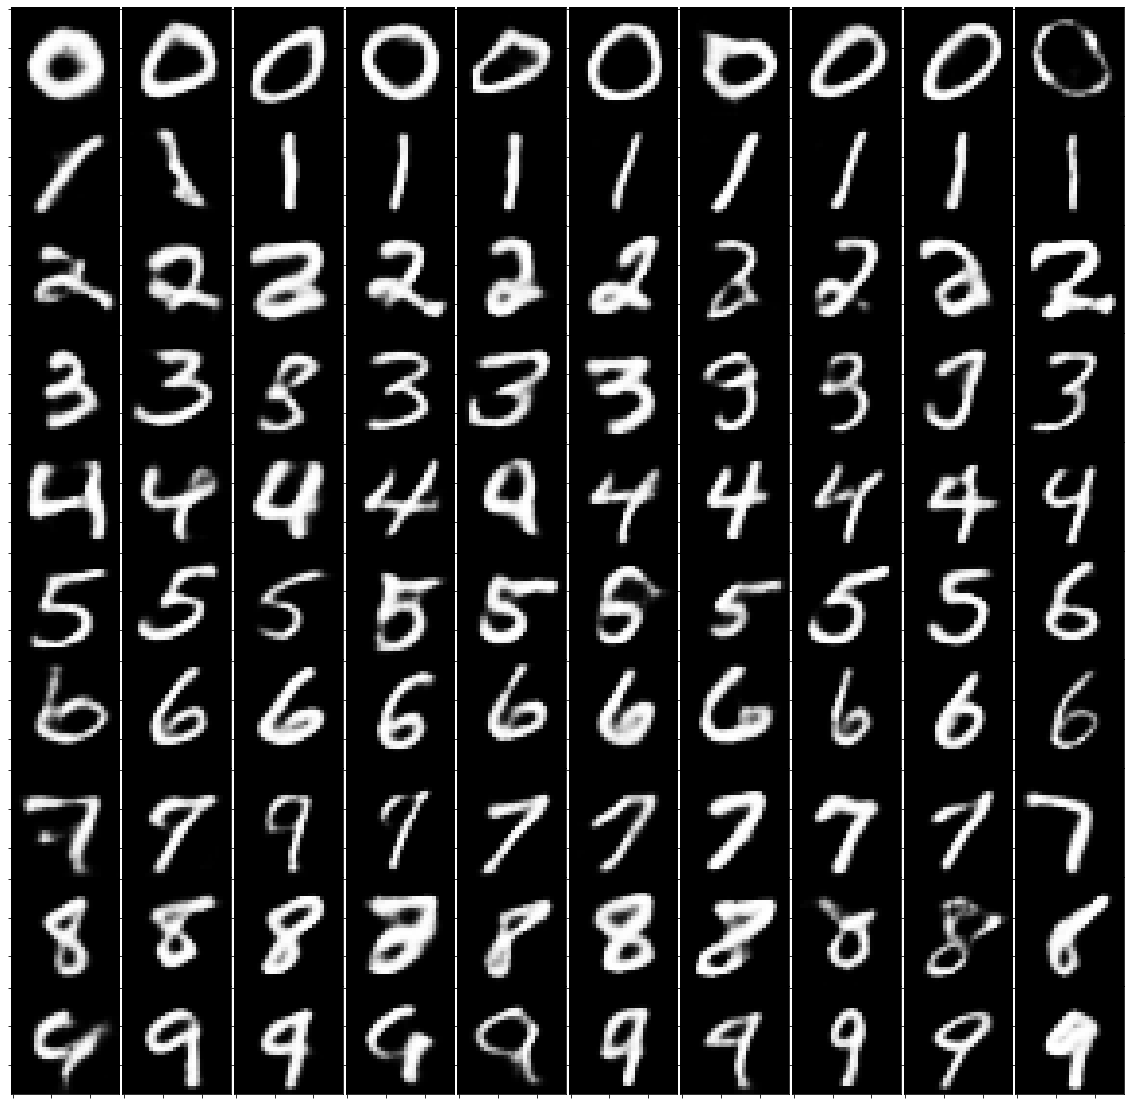

In [13]:
sample_n = 10
f, axs = plt.subplots(nrows=10, ncols=sample_n, figsize=(20, 20))

nf_model.eval()
with torch.no_grad():
    for j in range(10):

        y = torch.nn.functional.one_hot(torch.tensor([j]*sample_n), 10).to(device).float()
        emb, d = nf_model.sample(sample_n, y=y, return_logdet=True)
        z = autoencoder.decoder(emb)

        d_sorted = d.sort(0)[1].flip(0)
        z = z[d_sorted]
        z = torch.sigmoid(z).cpu()
        
        for i in range(sample_n):
            axs[j][i].imshow(z[i].reshape(28, 28), cmap='gray')

for ax in axs:
    for a in ax:
        a.set_xticklabels([])
        a.set_yticklabels([])
        a.set_aspect('equal')

f.subplots_adjust(wspace=0, hspace=0)
plt.show()
plt.close('all')